In [14]:

import re
import os
import cv2
import sys
import json
import math
import time
import random
import datetime
import numpy as np
import skimage.draw
import tensorflow as tf
import mrcnn.model as modellib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches

from mrcnn import utils
from mrcnn.model import log
from mrcnn import visualize
from mrcnn.config import Config
from mrcnn import model as modellib, utils
from mrcnn.visualize import display_images
from mrcnn.visualize import display_instances

import warnings
warnings.filterwarnings('ignore')

#import custom

# This is the root directory for this project work
DIR_ROOT = "D:\env_with_tensorflow1.14\gleason_mask_detector"

config = Config()

LOGS_DIR_DEFAULT = os.path.join(DIR_ROOT, "logs")

# Directory of the trained model

MODEL_DIR = os.path.join(DIR_ROOT, "logs")

# Paths to the weight files

PATH_WEIGHTS = "D:\\env_with_tensorflow1.14\\all_maskrcnn\\gleason_mask_detector\\logs\\object20210718T1243\\mask_rcnn_object_0100.h5"

# Configuration Used

In [15]:
# Training configurations for the model
class CustomConfig(config.__class__):
    # Run detection on one image at a time
    COUNT_GPU = 1
    IMAGES_PER_GPU = 1

config = CustomConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                13
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [16]:
class CustomConfig(Config):
    NAME = "object" # Name of the configuration
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 4  # background class + (Benign and Gleason pattern 3, Gleason pattern 4, Gleason pattern 5)
    STEPS_PER_EPOCH = 100 # Training steps per each epoch
    DETECTION_MIN_CONFIDENCE = 0.9 # Confidence level of detections (Skip detections if < 90% confidence level)

############################################################
#  Dataset Customisation
############################################################

class CustomDataset(utils.Dataset):
    def load_custom(self, dir_dataset, subset):
        # Adding the respective classes of the dataset
        self.add_class("object", 1, "Gleason_pattern_3")
        self.add_class("object", 2, "Gleason_pattern_4")
        self.add_class("object", 3, "Gleason_pattern_5")
        self.add_class("object", 4, "Benign")
        # Asserting the subsets of train and validation dataset
        assert subset in ["train", "val"]
        dir_dataset = os.path.join(dir_dataset, subset)

        
        # Loading the annotationfilevalues (We are interested in the x and y coordinates of each annotated image region)
        file_annotations = json.load(open('D://env_with_tensorflow1.14//all_maskrcnn//gleason_mask_detector//dataset//val//val.json'))        
        annotations = list(file_annotations.values())

        # Add images and get the x, y coordinates of polygons for each object instance
        annotations = [i for i in annotations if i['regions']]
        for i in annotations:
            shape_polygons = [r['shape_attributes'] for r in i['regions']] 
            objects = [s['region_attributes']['names'] for s in a['regions']]
            print("objects:",objects[:5])
            dict_name =  {"Gleason_pattern_3": 1,"Gleason_pattern_4": 2,"Gleason_pattern_5": 3,"Benign": 4}
            ids_num = [dict_name[i] for i in objects]
     
            # Reading the images to determine its size. 
            # load_mask() needs the image size to convert polygons to masks.
            print("ids_num",ids_num[:5])
            path_image = os.path.join(dir_dataset, i['filename'])
            image = skimage.io.imread(path_image)
            height, width = image.shape[:2]

            self.add_image(
                "object",  
                image_id = i['filename'],
                path = path_image,
                width = width, height = height,
                shape_polygons = shape_polygons,
                ids_num = ids_num
                )
    
    # Generating instance masks and class IDs for each image
    def load_mask(self, image_id):
        image_info = self.image_info[image_id]
        if image_info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)

        # Converting the polygons to bitmap masks of shape (height, width, instance_count)
        info = self.image_info[image_id]
        if info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)
        num_ids = info['num_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
        	rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])

        	mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        # Map class names to class IDs.
        num_ids = np.array(num_ids, dtype=np.int32)
        return mask, num_ids #np.ones([mask.shape[-1]], dtype=np.int32)
    
    # Returning image path
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        if info["source"] == "object":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)



# Model inspection (inference mode)

In [17]:

TEST_MODE = "inference" # Setting mode to inference
DIR_ROOT = "D:\\env_with_tensorflow1.14\\all_maskrcnn\\gleason_mask_detector\\dataset"

# This function returns a matplotlib array for all visualiations
def get_ax(rows=1, cols=1, size=16): 
  _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
  return ax

# Loading the dataset for validation
CUSTOM_DIR = "D:\\env_with_tensorflow1.14\\all_maskrcnn\\gleason_mask_detector\\dataset"
dataset = CustomDataset()
dataset.load_custom(CUSTOM_DIR, "val")
dataset.prepare()
print("Few Images from our validation: \nClasses present in our validation set: {}".format( dataset.class_names))



objects: ['Gleason_pattern_3']
numids [1]
objects: ['Gleason_pattern_3']
numids [1]
objects: ['Gleason_pattern_3', 'Gleason_pattern_4']
numids [1, 2]
objects: ['Gleason_pattern_4']
numids [2]
objects: ['Gleason_pattern_4']
numids [2]
objects: ['Gleason_pattern_3']
numids [1]
objects: ['Gleason_pattern_3', 'Gleason_pattern_4']
numids [1, 2]
objects: ['Gleason_pattern_3', 'Gleason_pattern_4']
numids [1, 2]
objects: ['Gleason_pattern_3']
numids [1]
objects: ['Gleason_pattern_3', 'Gleason_pattern_3', 'Gleason_pattern_3']
numids [1, 1, 1]
objects: ['Gleason_pattern_4']
numids [2]
objects: ['Gleason_pattern_4']
numids [2]
objects: ['Gleason_pattern_3', 'Gleason_pattern_4', 'Gleason_pattern_5']
numids [1, 2, 3]
objects: ['Gleason_pattern_4']
numids [2]
objects: ['Gleason_pattern_3', 'Gleason_pattern_3', 'Gleason_pattern_4', 'Gleason_pattern_4']
numids [1, 1, 2, 2]
objects: ['Gleason_pattern_3']
numids [1]
objects: ['Gleason_pattern_4', 'Gleason_pattern_5']
numids [2, 3]
objects: ['Gleason_pat

In [18]:
# Creating model(inference mode)
config = CustomConfig()
model = modellib.MaskRCNN(mode = "inference", model_dir = MODEL_DIR, config = config)


# Load  the last model trained

In [19]:

path_weights = PATH_WEIGHTS
# Load weights
print("Loading weights ", path_weights)
model.load_weights(path_weights, by_name = True)

Loading weights  D:\env_with_tensorflow1.14\all_maskrcnn\gleason_mask_detector\logs\object20210718T1243\mask_rcnn_object_0100.h5
Re-starting from epoch 100


# Below is the function for generating Gleason Scores.

In [20]:
# Function for generating Gleason scores from the detected Gleason patterns.
# This function reads through the colours of the images and automatically
# assigns a Gleason score to each image based on the colour of the detected image region.

import cv2
import numpy as np

def gleason_scores(img):
 frame = cv2.imread(img)
 #frame = cv2.resize(frame, (1400, 800))
 hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

 # Convert BGR to HSV
 hsvs = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

 # define range of blue color in HSV
 lower_blue = np.array([110,50,50])
 upper_blue = np.array([130,255,255])

 # define range of green color in HSV
 lower_green = np.array([41, 39, 64]) 
 upper_green = np.array([80, 255, 255])  

 yellow_lower=np.array([21, 39, 64]) 
 yellow_upper=np.array([40,255,255])

 red_lower=np.array([0, 39, 64]) 
 red_upper=np.array([20, 255, 255])

 # Threshold the HSV image to get only blue colors
 mask_blue = cv2.inRange(hsvs, lower_blue, upper_blue)
 mask_red = cv2.inRange(hsvs, red_lower, red_upper)
 mask_yellow = cv2.inRange(hsvs, yellow_lower, yellow_upper)
 mask_green = cv2.inRange(hsvs, lower_green, upper_green)

 # Bitwise-AND mask and original image
 res = cv2.bitwise_and(frame, frame, mask_blue)
 res2 = cv2.bitwise_and(frame, frame, mask_red)
 res3 = cv2.bitwise_and(frame, frame, mask_yellow)
 res4 = cv2.bitwise_and(frame, frame, mask_green)
	
 if np.sum(mask_blue) != 0 and np.sum(mask_yellow) != 0:
  gleason_score = "Gleason score 7"
  print("Gleason score 7 is an image with blue and yellow region")
  return gleason_score

 elif np.sum(mask_blue) != 0 and np.sum(mask_red) != 0:
  gleason_score = "Gleason score 8"
  print("Gleason score 8 (image with blue and red region)")
  return gleason_score
 elif np.sum(mask_yellow) != 0 and np.sum(mask_red) != 0:
  gleason_score = "Gleason Score 9"
  print("Gleason score 9  (image with yellow and red region)")
  return gleason_score
 elif np.sum(mask_red) != 0:
  gleason_score = "Gleason Score 10"
  print("score 10 is an image with only red region")
  return gleason_score
 elif np.sum(mask_blue) != 0:
  gleason_score = "Gleason Score 6"
  print("Gleason score 6")
  return gleason_score
 elif np.sum(mask_yellow) != 0:
  gleason_score = "Gleason Score 8"
  print("Gleason score 8 (only yellow region )")
  return gleason_score
 else:
  print("Gleason score not applicable")
  return ("Gleason score not applicable")



# Testing the Trained Model on any Image Dataset

### (Runing Gleason pattern detection and assigning Gleason scores

### by displaying the image with bounding boxes, and masks)


image ID: object.mask_ZT111_4_B_7_9 - Copy.png (88) D:\env_with_tensorflow1.14\all_maskrcnn\gleason_mask_detector\dataset\val\mask_ZT111_4_B_7_9 - Copy.png
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
gt_class_id              shape: (2,)                  min:    1.00000  max:    2.00000  int32
gt_bbox                  shape: (2, 4)                min:   15.00000  max: 1022.00000  int32
gt_mask                  shape: (1024, 1024, 2)       min:    0.00000  max:    1.00000  uint8


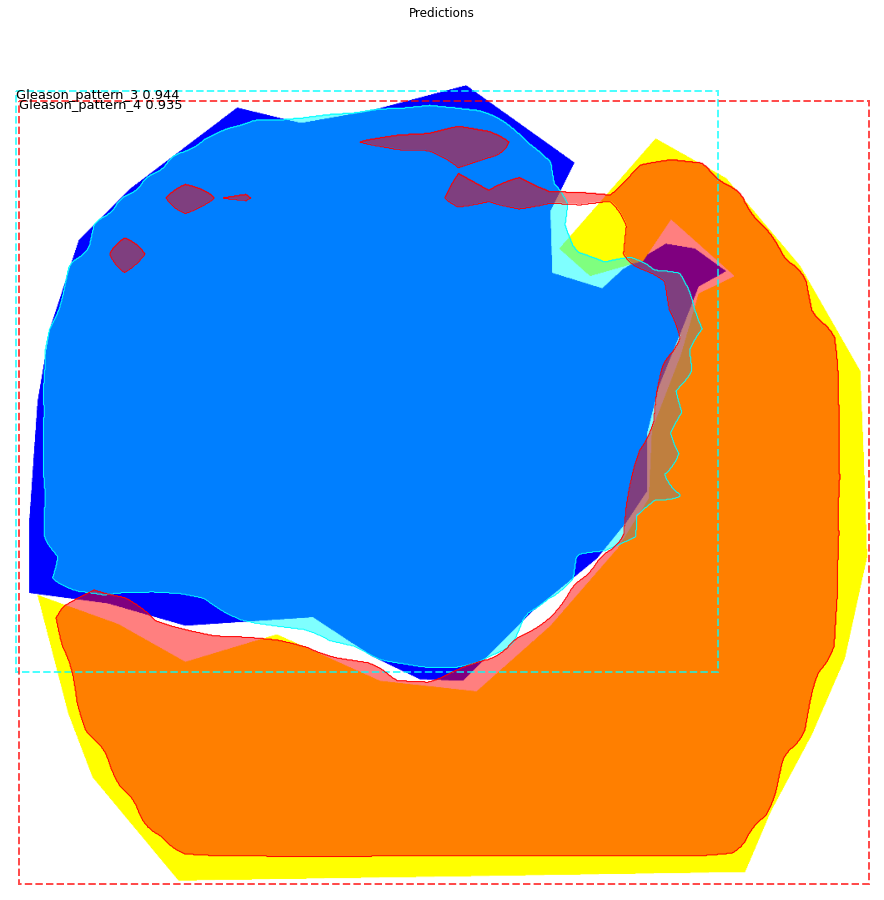

In [21]:
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))
# Running object detection function
results = model.detect([image], verbose=1)

img = "dataset/val/"+ info["id"] # variable used to read the image for gleason score
gleason_score_value = gleason_scores(img) # called gleason_score function

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions"  + gleason_score_value)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

image ID: object.mask_ZT111_4_C_1_1.png (33) D:\env_with_tensorflow1.14\all_maskrcnn\gleason_mask_detector\dataset\val\mask_ZT111_4_C_1_1.png
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
gt_class_id              shape: (6,)                  min:    1.00000  max:    2.00000  int32
gt_bbox                  shape: (6, 4)                min:    1.00000  max: 1009.00000  int32
gt_mask                  shape: (1024, 1024, 6)       min:    0.00000  max:    1.00000  uint8


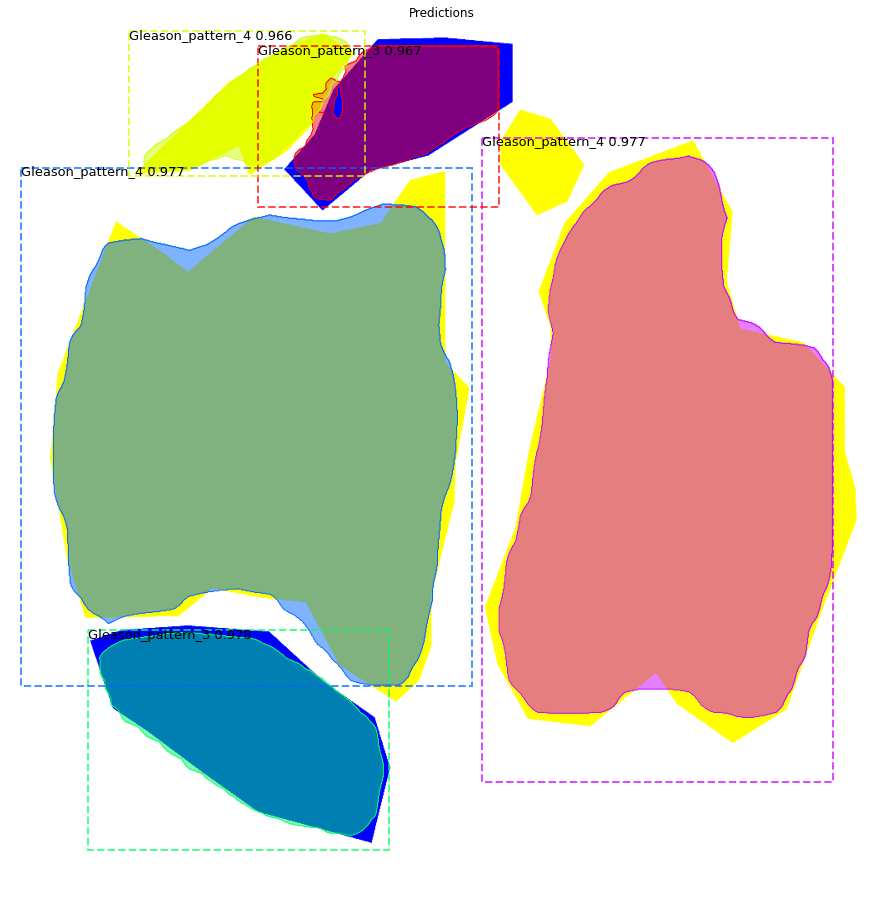

In [42]:

image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))
# Running object detection function
results = model.detect([image], verbose=1)

img = "dataset/val/"+ info["id"] # variable used to read the image for gleason score
gleason_score_value = gleason_scores(img) # called gleason_score function

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions" + gleason_score_value)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)




1
Processing 1 images
image                    shape: (3100, 3100, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max: 3100.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Gleason score 7 is an image with blue and yellow region


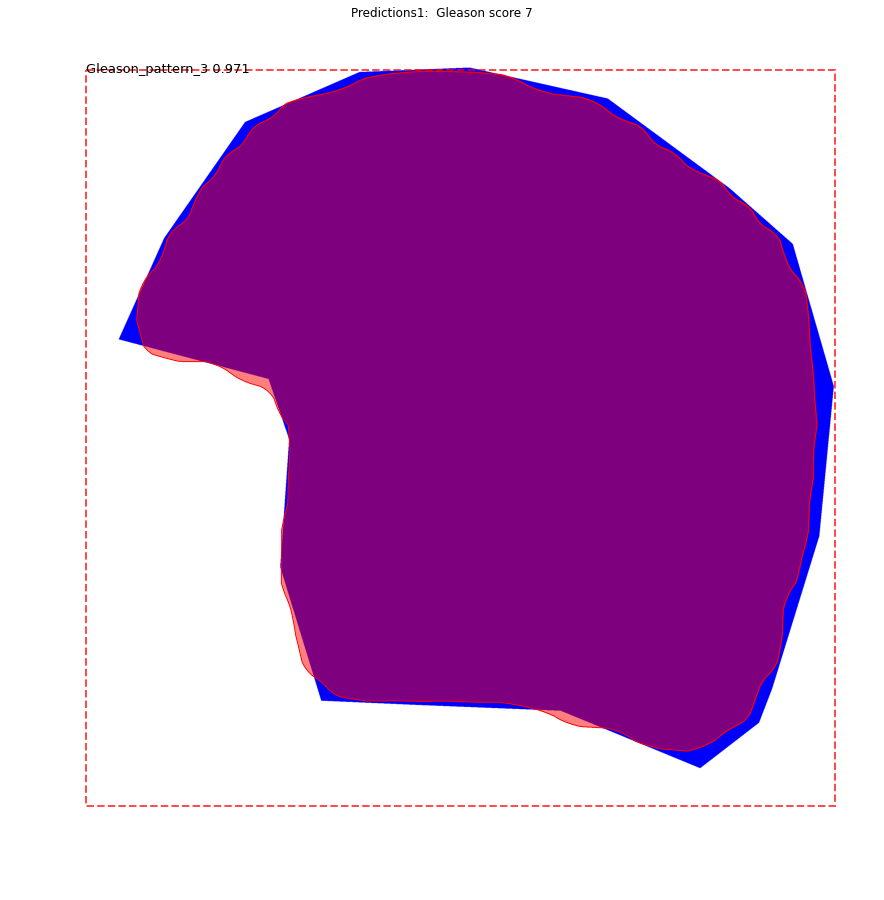

In [48]:
path_to_new_image = 'D:/env_with_tensorflow1.14/all_maskrcnn/gleason_mask_detector/dataset/Gleason_Test_Images/mask1_ZT80_38_A_1_2.png'

image1 = cv2.imread(path_to_new_image)
image1 = cv2.cvtColor(image1,cv2.COLOR_BGR2RGB)


# Running object detection function
print(len([image1]))
results1 = model.detect([image1], verbose=1)

img = "dataset/val/"+ info["id"] # variable used to read the image for gleason score
gleason_score_value = gleason_scores(img) # called gleason_score function

# Display results
ax = get_ax(1)
r1 = results1[0]
visualize.display_instances(image1, r1['rois'], r1['masks'], r1['class_ids'],
dataset.class_names, r1['scores'], ax=ax, title="Predictions1:  " + gleason_score_value )


1
Processing 1 images
image                    shape: (3100, 3100, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max: 3100.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Gleason score 7 is an image with blue and yellow region


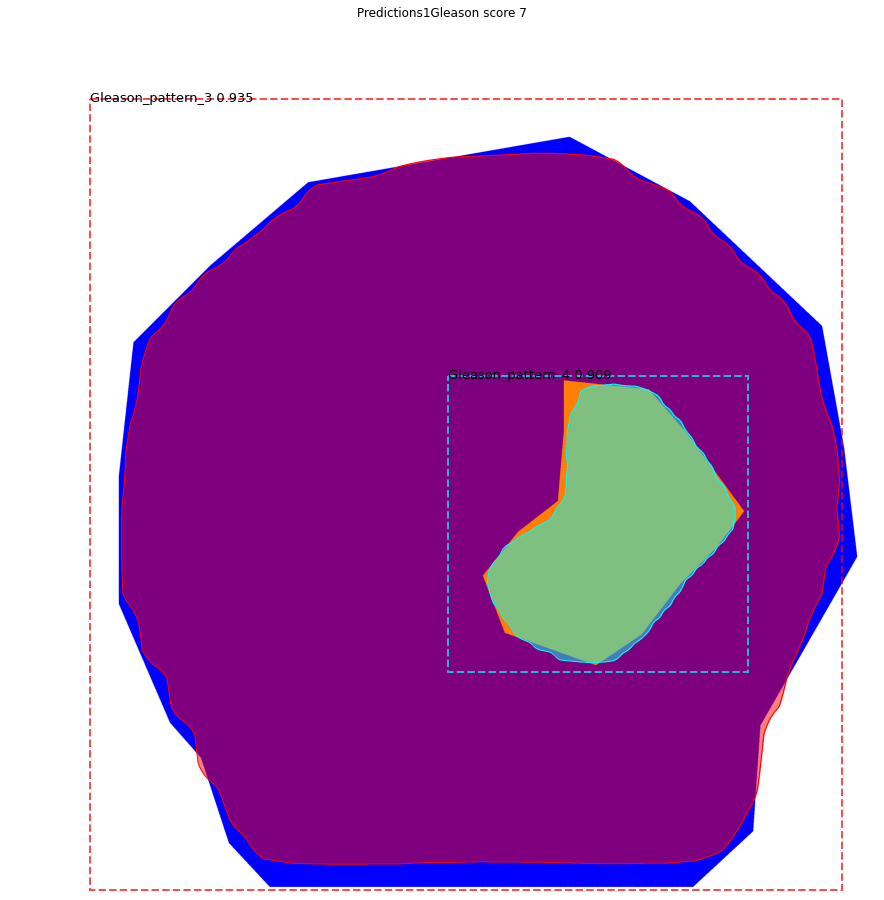

In [49]:
path_to_new_image = 'D:/env_with_tensorflow1.14/all_maskrcnn/gleason_mask_detector/dataset/Gleason_Test_Images/mask1_ZT80_38_A_1_13.png'

image1 = cv2.imread(path_to_new_image)
image1 = cv2.cvtColor(image1,cv2.COLOR_BGR2RGB)


# Running object detection function
print(len([image1]))
results1 = model.detect([image1], verbose=1)

img = "dataset/val/"+ info["id"] # variable used to read the image for gleason score
gleason_score_value = gleason_scores(img) # called gleason_score function

# Display results
ax = get_ax(1)
r1 = results1[0]
visualize.display_instances(image1, r1['rois'], r1['masks'], r1['class_ids'],
dataset.class_names, r1['scores'], ax=ax, title="Predictions1" + gleason_score_value )

image ID: object.mask_ZT111_4_B_5_10 - Copy.png (83) D:\env_with_tensorflow1.14\all_maskrcnn\gleason_mask_detector\dataset\val\mask_ZT111_4_B_5_10 - Copy.png
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -116.80000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
gt_class_id              shape: (1,)                  min:    3.00000  max:    3.00000  int32
gt_bbox                  shape: (1, 4)                min:   32.00000  max:  862.00000  int32
gt_mask                  shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  uint8


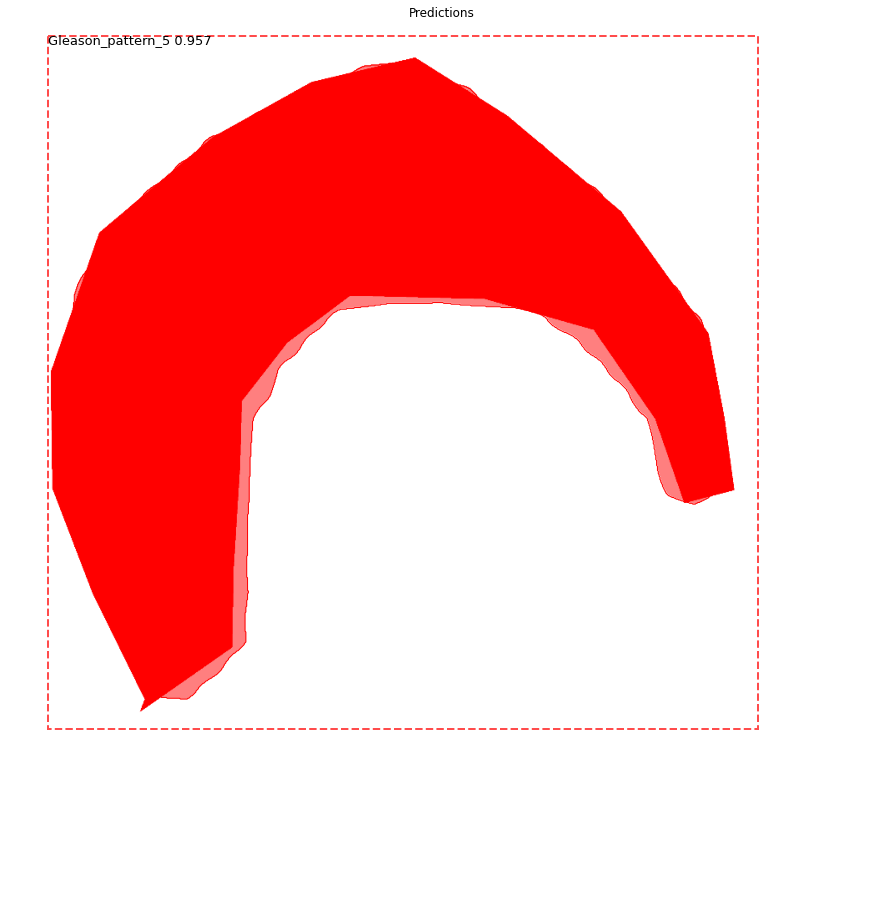

In [50]:
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))
# Running object detection function
results = model.detect([image], verbose=1)


img = "dataset/val/"+ info["id"] # variable used to read the image for gleason score
gleason_score_value = gleason_scores(img) # called gleason_score function

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions"  + gleason_score_value )
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

image ID: object.mask_ZT111_4_B_2_1 - Copy (2).png (132) D:\env_with_tensorflow1.14\all_maskrcnn\gleason_mask_detector\dataset\val\mask_ZT111_4_B_2_1 - Copy (2).png
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
gt_class_id              shape: (3,)                  min:    1.00000  max:    3.00000  int32
gt_bbox                  shape: (3, 4)                min:    8.00000  max: 1022.00000  int32
gt_mask                  shape: (1024, 1024, 3)       min:    0.00000  max:    1.00000  uint8


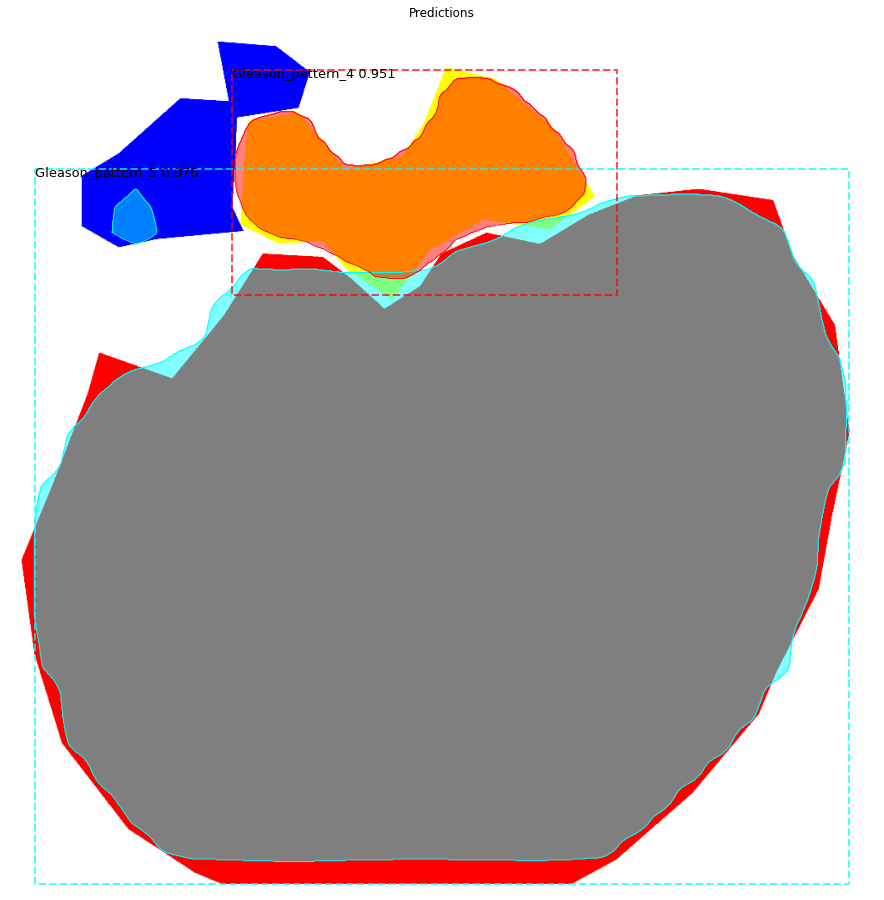

In [53]:
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))
# Running object detection function
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

# Calculating actual mean average precision for the whole images

In [55]:
import utils

gt_tot = np.array([])
pred_tot = np.array([])
# creating a list for mAP values
mAP_ = []
#compute gt_tot, pred_tot and mAP for each image in the test dataset
for image_id in dataset.image_ids:
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset, config, image_id)#, #use_mini_mask=False)
    info = dataset.image_info[image_id]

    # Run the model
    results = model.detect([image], verbose=1)
    r = results[0]
    
    # Compute gt_tot, pred_tot and mAP for each image in the test dataset
    gt, pred = utils.gt_pred_lists(gt_class_id, gt_bbox, r['class_ids'], r['rois'])
    gt_tot = np.append(gt_tot, gt)
    pred_tot = np.append(pred_tot, pred)
    
    # Calculating the values for precision_, recall_,and AP_ 
    AP_, precision_, recall_, overlap_ = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'])
    print("the actual len of the gt vect is : ", len(gt_tot))
    print("the actual len of the pred vect is : ", len(pred_tot))
    mAP_.append(AP_)
    print("Average precision of this image : ",AP_)

    
print("##########################################################################")
print("The actual mean average precision for the whole images ", sum(mAP_)/len(mAP_))
print("##########################################################################")

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual len of the gt vect is :  1
the actual len of the pred vect is :  1
Average precision of this image :  1.0
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
the actual len of the gt vect is :  2
the actual len of the pred vect is :  2
Avera

# Storing the Predictions in a seperate json file 

In [56]:
import pandas as pd
gt_tot=gt_tot.astype(int)
pred_tot=pred_tot.astype(int)
#saving the groundtruth and the prediction vectors
save_dir = "output"
gt_pred_tot_json = {"gt_tot" : gt_tot, "pred_tot" : pred_tot}
df = pd.DataFrame(gt_pred_tot_json)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
df.to_json(os.path.join(save_dir,"gt_pred_test.json"))


# Plotting confusion Matrix

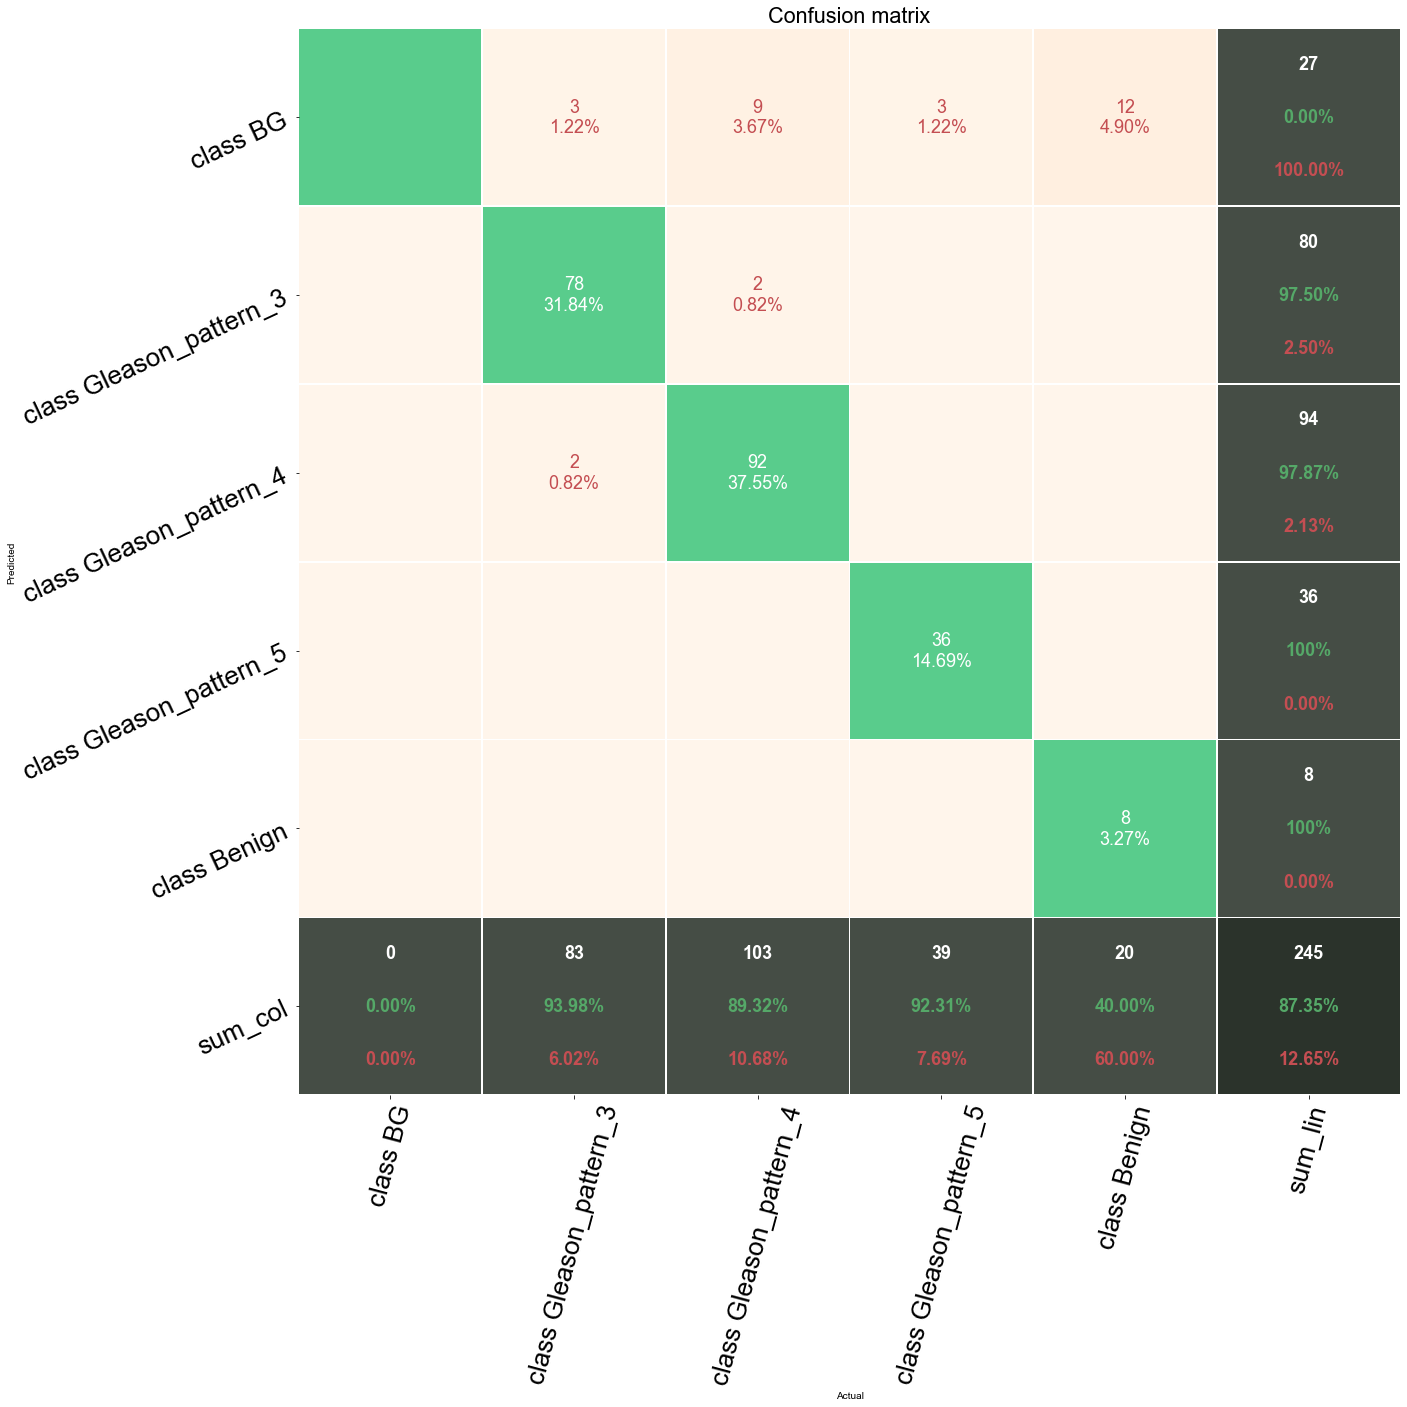

In [57]:

tp,fp,fn=utils.plot_confusion_matrix_from_data(gt_tot,pred_tot,fz=18, figsize=(20,20), lw=0.5)
# The vertical axis (column-wise) represents the ground-truth classes and
# the horizontal axis (row-wise) represents the predicted classes. 
# BG class is the background class.
# It is not taken into consideration calculating mAP values.